[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/allfed/Nutrition-calculator-allfed/blob/main/notebooks/example_optimize.ipynb)

# Rerun these each time you open colab

In [1]:

!rm -rf Nutrition-calculator-allfed/
!git clone -b main https://github.com/allfed/Nutrition-calculator-allfed.git

# This adds the Python files in our repo to our path so we can import
# them

import os
import sys

!pip install plotly
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scipy
!pip install seaborn
!pip install seaborn


os.chdir('/content/Nutrition-calculator-allfed/')


Cloning into 'Nutrition-calculator-allfed'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 15), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (29/29), 3.55 MiB | 4.75 MiB/s, done.
Resolving deltas: 100% (15/15), done.


FileNotFoundError: [Errno 2] No such file or directory: '/content/Nutrition-calculator-allfed/'

# Charts of food combinations
This Jupyter Notebook aims at creating charts and food tables for the food combinations found (for now, found incrementally---ideally it should come from an algorithm that should be more objective, see the Optimization notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg, optimize
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
#import dataframe_image as dfi

In [2]:
nut_calc = pd.read_excel('Nutrition Calculator.xlsx', sheet_name='Nutrition Calculator (p100kcal)',
                         skiprows=(0,1,3), index_col=0)
nut_needs = pd.read_excel('Nutrition Calculator.xlsx', sheet_name='Human Nutritional Needs',
                          nrows=5, skiprows=(0,2), index_col=0)

In [3]:
nut_calc = nut_calc.fillna(0)

In [4]:
df_columns_names = pd.read_excel('Nutrition Calculator.xlsx', sheet_name='Human Nutritional Needs')
nutrient_names = list(df_columns_names.iloc[0])[1:]
unit = list(df_columns_names.iloc[1])[1:]
for i in range(len(nutrient_names)):
    nutrient_names[i] = nutrient_names[i]+' ('+unit[i]+')'
print(nutrient_names)

['Protein (g)', 'Fat total (g)', 'Saturated fats (g)', 'Trans fats (g)', 'Carbohydrates (g)', 'Fiber (g)', 'Sugars (g)', 'Vitamin A (µg)', 'Vitamin E (µg)', 'Vitamin D (µg)', 'Vitamin C (mg)', 'Thiamine (B1) (mg)', 'Riboflavin (B2) (mg)', 'Niacin (B3) (mg)', 'Vitamin B6 (mg)', 'Vitamin B12 (µg)', 'Vitamin K (µg)', 'Folate (B9) (µg)', 'Pantothenic Acid (B5) (mg)', 'Calcium (mg)', 'Iron (mg)', 'Magnesium (mg)', 'Phosphorus (mg)', 'Potassium (mg)', 'Sodium (mg)', 'Zinc (mg)', 'Copper (µg)', 'Manganese (mg)', 'Selenium (µg)', 'Iodine (µg)', 'Chromium (µg)', 'Molybdenum (µg)', 'Histidine (g)', 'Isoleucine (g)', 'Leucine (g)', 'Lysine (g)', 'Methionine (g)', 'Cysteine (g)', 'Phenylalanine (g)', 'Tyrosine (g)', 'Threonine (g)', 'Tryptophan (g)', 'Valine (g)', 'Omega-3 (ALA) (g)', 'Omega-6 (LA) (g)']


In [5]:
nut_needs.columns = nutrient_names
nut_needs

Protein (g)  Fat total (g)  Saturated fats (g)  \
Lower (severe risk)           46.00          35.00        1.000000e-99   
Lower (moderate risk)         51.00          46.67        1.000000e-99   
Higher (safe)                 78.75          70.00        2.333000e+01   
Higher (moderate risk)       140.00          81.67        2.000000e+02   
Higher (severe risk)         400.00         200.00        2.000000e+02   

                        Trans fats (g)  Carbohydrates (g)     Fiber (g)  \
Lower (severe risk)       1.000000e-99       5.000000e+01  2.500000e+01   
Lower (moderate risk)     1.000000e-99       1.300000e+02  2.500000e+01   
Higher (safe)             2.300000e+00       4.000000e+02  7.000000e+01   
Higher (moderate risk)    2.000000e+02       5.000000e+02  5.000000e+02   
Higher (severe risk)      2.000000e+02       1.000000e+99  1.000000e+99   

                          Sugars (g)  Vitamin A (µg)  Vitamin E (µg)  \
Lower (severe risk)     1.000000e-99    5.000000e+02    1.000000e+04   
Lower (moderate risk)   1.000000e-99    7.000000e+02    1.500000e+04   
Higher (safe)           5.250000e+01    3.000000e+03    3.000000e+05   
Higher (moderate risk)  1.312500e+02    8.000000e+03    1.000000e+06   
Higher (severe risk)    1.000000e+99    1.000000e+99    1.000000e+99   

                        Vitamin D (µg)  ...    Lysine (g)  Methionine (g)  \
Lower (severe risk)                3.8  ...  1.860000e+00    6.200000e-01   
Lower (moderate risk)             15.0  ...  1.860000e+00    6.200000e-01   
Higher (safe)                    250.0  ...  7.440000e+00    2.480000e+00   
Higher (moderate risk)          1925.0  ...  1.000000e+99    1.000000e+99   
Higher (severe risk)           15000.0  ...  1.000000e+99    1.000000e+99   

                        Cysteine (g)  Phenylalanine (g)  Tyrosine (g)  \
Lower (severe risk)     2.480000e-01       9.300000e-01  2.480000e-01   
Lower (moderate risk)   2.480000e-01       9.300000e-01  2.480000e-01   
Higher (safe)           9.920000e-01       3.720000e+00  9.920000e-01   
Higher (moderate risk)  1.000000e+99       1.000000e+99  1.000000e+99   
Higher (severe risk)    1.000000e+99       1.000000e+99  1.000000e+99   

                        Threonine (g)  Tryptophan (g)    Valine (g)  \
Lower (severe risk)      9.300000e-01    2.480000e-01  1.612000e+00   
Lower (moderate risk)    9.300000e-01    2.480000e-01  1.612000e+00   
Higher (safe)            3.720000e+00    9.920000e-01  6.448000e+00   
Higher (moderate risk)   1.000000e+99    1.000000e+99  1.000000e+99   
Higher (severe risk)     1.000000e+99    1.000000e+99  1.000000e+99   

                        Omega-3 (ALA) (g)  Omega-6 (LA) (g)  
Lower (severe risk)          1.350000e+00      1.000000e+01  
Lower (moderate risk)        2.000000e+00      1.450000e+01  
Higher (safe)                2.800000e+00      1.867000e+01  
Higher (moderate risk)       4.670000e+00      2.333000e+01  
Higher (severe risk)         1.000000e+99      1.000000e+99  

[5 rows x 45 columns]

In [6]:
nut_calc = nut_calc.drop('Notes', axis=1)
nut_calc = nut_calc.drop('Source', axis=1)
nut_calc = nut_calc.drop('Energy', axis=1)
nut_calc = nut_calc.drop('Protein digestibility', axis=1)
nut_calc.columns = nutrient_names
nut_calc

Protein (g)  Fat total (g)  Saturated fats (g)  \
Food                                                                           
Potatoes                         2.149425       0.114943            0.029885   
Wheat flour                      2.837912       0.269231            0.042582   
Wheat (hard red spring)          4.680851       0.583587            0.095441   
Bread (whole-wheat)              3.021583       1.942446            0.286331   
Barley (pearled)                 1.837398       0.357724            0.075610   
Canola oil                       0.000000      11.312217            0.833145   
Canola meal                     10.654935       0.922258            0.071618   
Rice (white)                     2.069231       0.215385            0.059231   
Rice (brown)                     2.227642       0.788618            0.211382   
Corn flour (whole-grain)         1.919668       1.069252            0.150416   
Corn                             3.552083       1.562500            0.205208   
Soy flour                        8.711982       4.758065            0.688249   
Soybeans                        10.581395       5.215116            0.755814   
Anchovy (raw)                   15.534351       3.694656            0.978626   
Cattle (lean)                   14.729064       4.123153            1.600985   
Cattle (fat)                     1.558824      10.338235            4.191176   
Cattle (organs)                 14.722854       3.494903            1.369257   
Milk (whole)                     5.163934       5.360656            3.057377   
Sugar (beets)                    0.000000       0.083117            0.000000   
Spirulina (dry)                 19.817241       2.662069            0.913793   
Emi-tsunomata (dry)              5.922780       0.536680            0.173745   
Kelp (dry)                       3.906977       1.302326            0.574419   
Laver (dry)                     16.600000       0.800000            0.174286   
Wakame (dry)                     6.733333       1.422222            0.288889   
Bacteria (methane)              13.027757       1.626236            0.123194   
Lignocellulosic sugar            0.000000       0.000000            0.000000   
NaN                              0.000000       0.000000            0.000000   
Mushrooms, shiitake, raw         6.588235       1.441176            0.000000   
Mushrooms, oyster, raw          10.030303       1.242424            0.187879   
Meat and bone meal, high-fat    12.977492       2.694780            0.000000   

                              Trans fats (g)  Carbohydrates (g)  Fiber (g)  \
Food                                                                         
Potatoes                            0.000000          23.137931   2.068966   
Wheat flour                         0.000000          20.964286   0.741758   
Wheat (hard red spring)             0.000000          20.668693   3.708207   
Bread (whole-wheat)                 0.000000          18.489209   2.158273   
Barley (pearled)                    0.000000          22.926829   3.089431   
Canola oil                          0.044683           0.000000   0.000000   
Canola meal                         0.000000          12.269983   9.631827   
Rice (white)                        0.000000          21.692308   0.307692   
Rice (brown)                        0.000000          20.813008   1.300813   
Corn flour (whole-grain)            0.000000          21.274238   2.022161   
Corn                                0.000000          21.875000   2.500000   
Soy flour                           0.000000           7.354839   2.211982   
Soybeans                            0.000000           4.860465   3.488372   
Anchovy (raw)                       0.000000           0.000000   0.000000   
Cattle (lean)                       0.127586           0.000000   0.000000   
Cattle (fat)                        0.000000           0.000000   0.000000   
Cattle (organs)                     0.144928           1.504420  

I - OS 
-------
 Protein (g)                    125.531323
Fat total (g)                   61.809170
Saturated fats (g)              14.239321
Trans fats (g)                   0.412003
Carbohydrates (g)              268.894826
Fiber (g)                       28.509495
Sugars (g)                      27.196245
Vitamin A (µg)                2774.988725
Vitamin E (µg)                5693.381266
Vitamin D (µg)                   0.689763
Vitamin C (mg)                  61.106531
Thiamine (B1) (mg)               1.455572
Riboflavin (B2) (mg)             3.183660
Niacin (B3) (mg)                39.856927
Vitamin B6 (mg)                  2.879357
Vitamin B12 (µg)                26.467544
Vitamin K (µg)                  73.207216
Folate (B9) (µg)               418.840570
Pantothenic Acid (B5) (mg)       9.009312
Calcium (mg)                   735.119269
Iron (mg)                       23.491059
Magnesium (mg)                 562.478095
Phosphorus (mg)               1730.666613
Potassium (mg)   

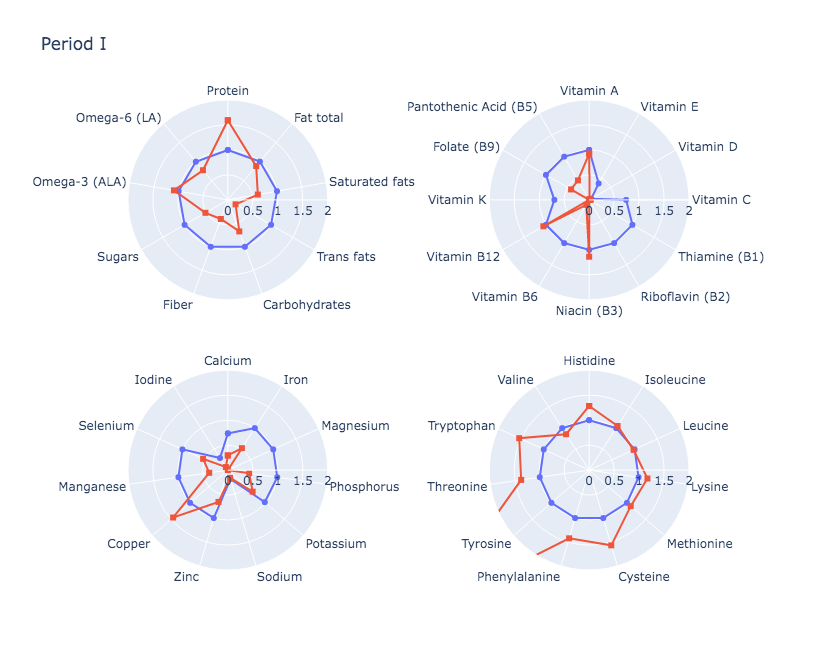

I - AS 
-------
 Protein (g)                    169.584313
Fat total (g)                   56.012203
Saturated fats (g)              23.007425
Trans fats (g)                   0.936457
Carbohydrates (g)              225.488024
Fiber (g)                       13.448276
Sugars (g)                      27.495572
Vitamin A (µg)                4594.120714
Vitamin E (µg)                2359.947102
Vitamin D (µg)                   1.318590
Vitamin C (mg)                 112.238470
Thiamine (B1) (mg)               1.398547
Riboflavin (B2) (mg)             4.072418
Niacin (B3) (mg)                61.914678
Vitamin B6 (mg)                  4.474811
Vitamin B12 (µg)                48.170540
Vitamin K (µg)                  23.016527
Folate (B9) (µg)               257.202024
Pantothenic Acid (B5) (mg)      11.976992
Calcium (mg)                   877.584873
Iron (mg)                       24.647078
Magnesium (mg)                 359.889588
Phosphorus (mg)               1973.087023
Potassium (mg)   

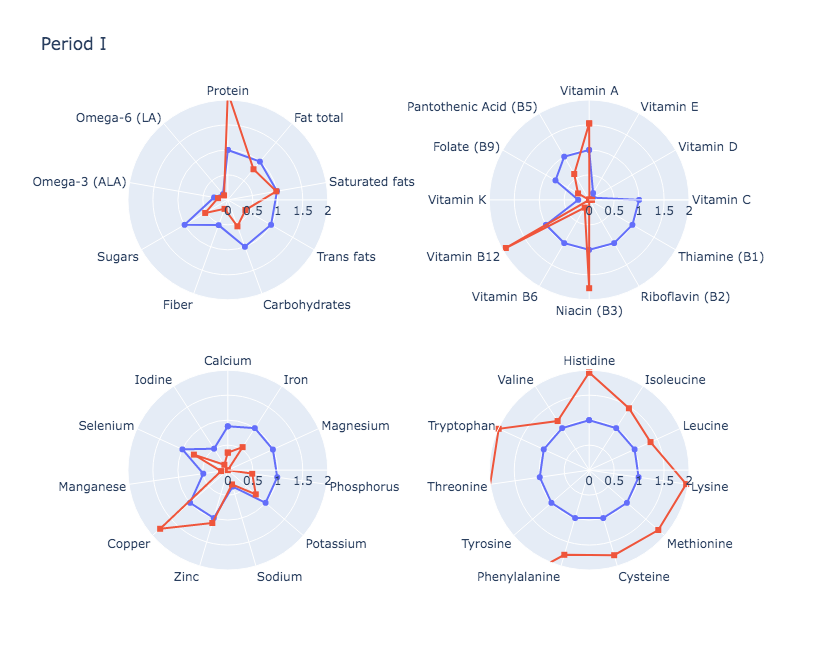

II - OS 
-------
 Protein (g)                     108.241313
Fat total (g)                    58.096036
Saturated fats (g)               13.590742
Trans fats (g)                    0.218788
Carbohydrates (g)               303.298304
Fiber (g)                        47.770829
Sugars (g)                       22.205821
Vitamin A (µg)                 2135.272069
Vitamin E (µg)                10505.719525
Vitamin D (µg)                    1.655562
Vitamin C (mg)                  196.675479
Thiamine (B1) (mg)                2.297297
Riboflavin (B2) (mg)              3.765298
Niacin (B3) (mg)                 40.837561
Vitamin B6 (mg)                   3.821056
Vitamin B12 (µg)                 14.336719
Vitamin K (µg)                   82.160457
Folate (B9) (µg)                756.634547
Pantothenic Acid (B5) (mg)        9.575134
Calcium (mg)                    821.481599
Iron (mg)                        45.941077
Magnesium (mg)                  878.342280
Phosphorus (mg)                1697.

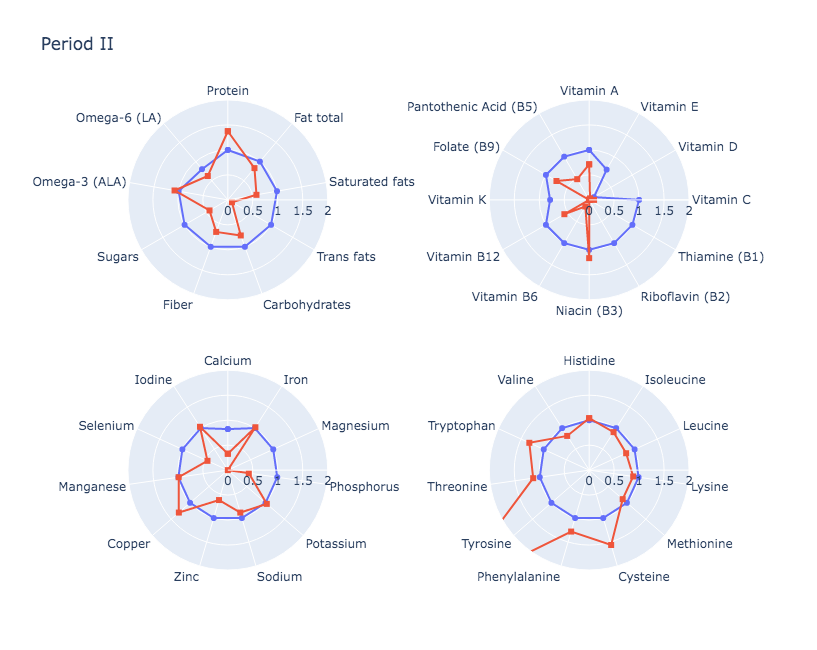

II - AS 
-------
 Protein (g)                     89.868533
Fat total (g)                   56.959357
Saturated fats (g)              13.286282
Trans fats (g)                   0.218788
Carbohydrates (g)              318.245022
Fiber (g)                       32.958088
Sugars (g)                      65.955821
Vitamin A (µg)                1421.372455
Vitamin E (µg)                6239.310258
Vitamin D (µg)                   0.458651
Vitamin C (mg)                 101.907140
Thiamine (B1) (mg)               1.901968
Riboflavin (B2) (mg)             2.195684
Niacin (B3) (mg)                36.239685
Vitamin B6 (mg)                  3.391539
Vitamin B12 (µg)                13.467993
Vitamin K (µg)                  73.589029
Folate (B9) (µg)               371.190532
Pantothenic Acid (B5) (mg)       8.458705
Calcium (mg)                   556.037583
Iron (mg)                       16.454591
Magnesium (mg)                 606.875099
Phosphorus (mg)               1472.961397
Potassium (mg)  

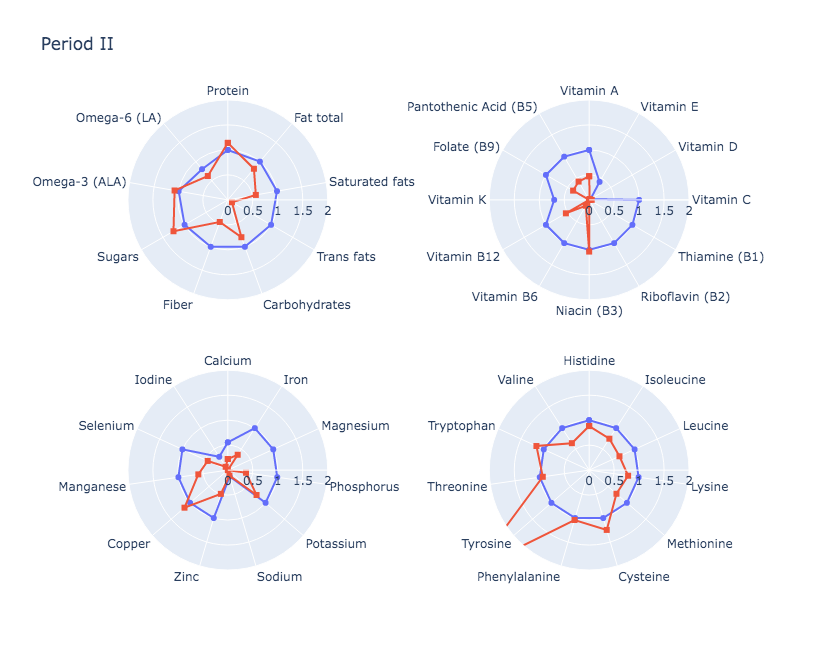

III- OS 
-------
 Protein (g)                     107.689318
Fat total (g)                    46.742757
Saturated fats (g)                6.154311
Trans fats (g)                    0.089367
Carbohydrates (g)               323.058036
Fiber (g)                        52.135832
Sugars (g)                       14.624919
Vitamin A (µg)                  567.504233
Vitamin E (µg)                10989.080073
Vitamin D (µg)                    1.237895
Vitamin C (mg)                  153.244430
Thiamine (B1) (mg)                2.950709
Riboflavin (B2) (mg)              5.837616
Niacin (B3) (mg)                 32.935712
Vitamin B6 (mg)                   3.217526
Vitamin B12 (µg)                  1.053152
Vitamin K (µg)                   82.805686
Folate (B9) (µg)                707.114386
Pantothenic Acid (B5) (mg)        7.312128
Calcium (mg)                    672.654035
Iron (mg)                        59.743871
Magnesium (mg)                 1018.301248
Phosphorus (mg)                2088.

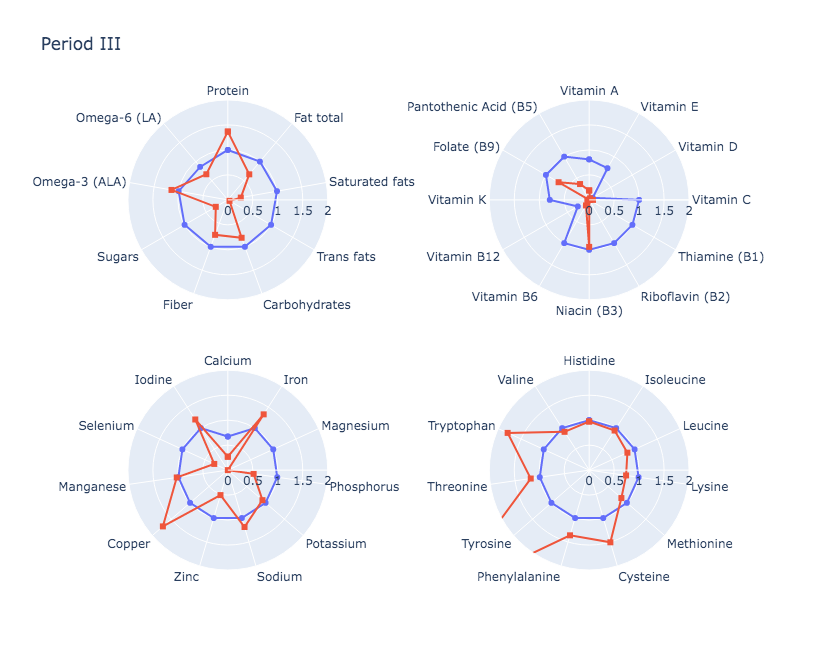

III - AS 
-------
 Protein (g)                      88.158492
Fat total (g)                    59.563103
Saturated fats (g)               12.915584
Trans fats (g)                    0.111708
Carbohydrates (g)               310.123166
Fiber (g)                        46.033819
Sugars (g)                       35.044799
Vitamin A (µg)                  562.037787
Vitamin E (µg)                11090.166042
Vitamin D (µg)                    1.355542
Vitamin C (mg)                  152.503151
Thiamine (B1) (mg)                2.598003
Riboflavin (B2) (mg)              5.214307
Niacin (B3) (mg)                 30.597739
Vitamin B6 (mg)                   2.870415
Vitamin B12 (µg)                  1.317858
Vitamin K (µg)                   51.484160
Folate (B9) (µg)                543.282599
Pantothenic Acid (B5) (mg)        6.450926
Calcium (mg)                    553.921712
Iron (mg)                        55.231352
Magnesium (mg)                  789.802963
Phosphorus (mg)                1742

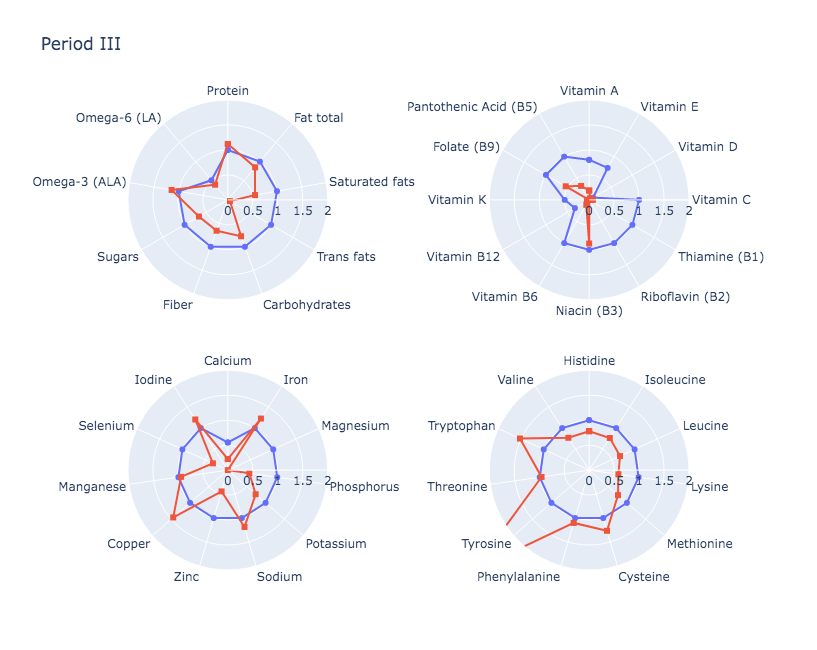

In [8]:
diets_excel=pd.ExcelFile("Diets by period.xlsx")

for sheet in diets_excel.sheet_names:
    diets = pd.read_excel("Diets by period.xlsx", index_col=0, sheet_name=sheet)
    diets = diets.fillna(0)
    diets = diets.drop('Total:')
    food_subset_2 = diets.index
    nut_calc_subset=nut_calc.loc[list(food_subset_2)]
    fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)
    nut_calc_subset_t=nut_calc_subset[nut_needs.columns].T
    diet = nut_calc_subset_t @ (diets['kcal']/100)
    diet_df = pd.DataFrame(diet, columns=['value'])
    print(sheet, '\n-------\n', diet)
    
    SRAI = []
    MRAI = []
    AI = []
    danger = []
    for i in range(len(diet)): # for the solution, divide in categories for each nutrient
        nutrient=diet[i]
        nut=diet.index[i]
        lower_severe = nut_needs.at['Lower (severe risk)', nut]
        lower_moderate = nut_needs.at['Lower (moderate risk)', nut]
        higher_safe = nut_needs.at['Higher (safe)', nut]
        higher_moderate = nut_needs.at['Higher (moderate risk)', nut]
        higher_severe = nut_needs.at['Higher (severe risk)', nut]
        if (nutrient>= lower_moderate) and (nutrient<=higher_safe):
            AI += [nut]
        elif (nutrient==0):
            danger+= [nut + ' 0%']
        elif (nutrient>higher_severe):
            danger+= [nut + ' ' + str(round(nutrient/higher_safe*100))+'%']
        elif (nutrient<lower_severe):
            SRAI += [nut + ' ' + str(round(nutrient/lower_moderate*100))+'%']
        elif (nutrient>higher_moderate):
            SRAI += [nut + ' ' + str(round(nutrient/higher_safe*100))+'%']
        elif (nutrient< lower_moderate):
            MRAI += [nut + ' ' + str(round(nutrient/lower_moderate*100))+'%']
        elif (nutrient>higher_safe):
            MRAI += [nut + ' ' + str(round(nutrient/higher_safe*100))+'%']
    print('AI', AI, '\n\nMRAI', MRAI, '\n\nSRAI', SRAI, '\n\nDanger', danger)
    
    
    nut_needs_wo_unit = pd.read_excel('Nutrition Calculator.xlsx', sheet_name='Human Nutritional Needs',
                          nrows=5, skiprows=(0,2), index_col=0)
    nutrient_names_wo_unit = list(nut_needs_wo_unit.columns)
    
    nutrients = [nutrient_names_wo_unit[:7]+nutrient_names_wo_unit[-2:],
                 nutrient_names_wo_unit[7:19],
                 nutrient_names_wo_unit[19:30],
                 nutrient_names_wo_unit[32:43]]

    diet_df.index = nut_needs_wo_unit.columns
    diet_df['lower adequate intake'] = pd.Series(nut_needs_wo_unit.T['Lower (moderate risk)'])
    diet_df['upper adequate intake'] = pd.Series(nut_needs_wo_unit.T['Higher (safe)'])
    diet_df['% lower adequate intake'] = diet_df['value']/diet_df['lower adequate intake']
    diet_df.loc[diet_df['% lower adequate intake']>1, '% lower adequate intake']=1
    diet_df['% upper adequate intake'] = diet_df['value']/diet_df['upper adequate intake']
    diet_macro = diet_df.loc[nutrients[0]]
    diet_macro = diet_macro.append(diet_macro.iloc[[0]])
    fig.add_trace(go.Scatterpolar(r=diet_macro['% lower adequate intake'], theta=diet_macro.index,
                                  name='% lower adequate intake', line_color='#636EFA'), 1, 1)
    fig.add_trace(go.Scatterpolar(r=diet_macro['% upper adequate intake'], theta=diet_macro.index,
                                  name='% upper adequate intake', line_color='#EF553B',
                                  marker_symbol='square', marker_size=6), 1, 1)
    
    diet_vit = diet_df.loc[nutrients[1]]
    diet_vit = diet_vit.append(diet_vit.iloc[[0]])
    fig.add_trace(go.Scatterpolar(r=diet_vit['% lower adequate intake'], theta=diet_vit.index,
                                  name='% lower adequate intake', line_color='#636EFA'), 1, 2)
    fig.add_trace(go.Scatterpolar(r=diet_vit['% upper adequate intake'], theta=diet_vit.index,
                                  name='% upper adequate intake', line_color='#EF553B',
                                  marker_symbol='square', marker_size=6), 1, 2)
    diet_min = diet_df.loc[nutrients[2]]
    diet_min = diet_min.append(diet_min.iloc[[0]])
    fig.add_trace(go.Scatterpolar(r=diet_min['% lower adequate intake'], theta=diet_min.index,
                                  name='% lower adequate intake', line_color='#636EFA'), 2, 1)
    fig.add_trace(go.Scatterpolar(r=diet_min['% upper adequate intake'], theta=diet_min.index,
                                  name='% upper adequate intake', line_color='#EF553B',
                                  marker_symbol='square', marker_size=6), 2, 1)
    diet_aa = diet_df.loc[nutrients[3]]
    diet_aa = diet_aa.append(diet_aa.iloc[[0]])
    fig.add_trace(go.Scatterpolar(r=diet_aa['% lower adequate intake'], theta=diet_aa.index,
                                  name='% lower adequate intake', line_color='#636EFA'), 2, 2)
    fig.add_trace(go.Scatterpolar(r=diet_aa['% upper adequate intake'], theta=diet_aa.index,
                                  name='% upper adequate intake', line_color='#EF553B',
                                  marker_symbol='square', marker_size=6), 2, 2)
    max_val = 2
    text = sheet.split('-')
    title='Period '+text[0]
    if text[1]=='OS':
        title+=' diet - optimistic scenario'
    elif text[1][:2]=='AS':
        title+=' diet - alternative scenario'
        
    fig.update_layout(
        height=650, width=850, title_text=title,
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, max_val]
        ),
      angularaxis = dict(
        rotation = 90,
        direction = "clockwise"
      )),
      polar2=dict(
        radialaxis=dict(
          visible=True,
          range=[0, max_val]
        ),
          angularaxis = dict(
        rotation = 90,
        direction = "clockwise"
      )),
      polar3=dict(
        radialaxis=dict(
          visible=True,
          range=[0, max_val]
        ),
      angularaxis = dict(
        rotation = 90,
        direction = "clockwise"
      )),
      polar4=dict(
        radialaxis=dict(
          visible=True,
          range=[0, max_val]
        ),
      angularaxis = dict(
        rotation = 90,
        direction = "clockwise"
      )),
      showlegend=False
    )
    fig.show()
    fig.write_image(title+'.png', width=850, height=650, scale=3)

In [ ]:
diets_excel=pd.ExcelFile("Diets by period.xlsx")

sheets = diets_excel.sheet_names
for i in range(3):
    diets1 = pd.read_excel("Diets by period.xlsx", index_col=0, sheet_name=sheets[i*2])
    diets1.columns = ['OS g', 'OS kcal']
    diets2 = pd.read_excel("Diets by period.xlsx", index_col=0, sheet_name=sheets[i*2+1])
    diets2.columns = ['AS g', 'AS kcal']
    diets = diets1.join(diets2, how='outer', sort=False)
    diets = diets.fillna(0)
    diets = diets.drop('Total:')
    diets_final = pd.DataFrame(diets, columns = ['OS kcal', 'AS kcal', 'OS g', 'AS g'], dtype=int)
    
    text = sheets[i*2].split('-')
    title='Period '+text[0]
    print(title, '\n', diets_final)

    dfi.export(diets_final, title+' table.png')

In [7]:
diets_excel=pd.ExcelFile("Diets by period.xlsx")

sheets = diets_excel.sheet_names
diets_to_table = pd.DataFrame(index=['Potatoes',
                'Wheat flour','Wheat (hard red spring)','Barley (pearled)','Canola oil',
                'Rice (white)','Rice (brown)','Corn flour (whole-grain)','Corn','Soy flour','Soybeans',
                'Anchovy (raw)',
                'Cattle (lean)','Cattle (fat)','Cattle (organs)',
                'Milk (whole)',
                'Sugar (beets)',
                'Spirulina (dry)','Emi-tsunomata (dry)','Laver (dry)','Wakame (dry)',
                'Bacteria (methane)',
                'Lignocellulosic sugar'])
for sheet in sheets:
    diets_to_add = pd.read_excel("Diets by period.xlsx", index_col=0, sheet_name=sheet)
    diets_to_add.columns = [sheet+' (g)', sheet+' (kcal)']
    diets_to_table = diets_to_table.join(diets_to_add, sort=False)
    diets_to_table = diets_to_table.fillna('-')


arrays=[['Period I','Period I','Period I','Period I',
         'Period II','Period II','Period II','Period II',
         'Period III','Period III','Period III','Period III'],
        ['Optimistic scenario','Optimistic scenario','Pessimistic scenario','Pessimistic scenario',
         'Optimistic scenario','Optimistic scenario','Pessimistic scenario','Pessimistic scenario',
         'Optimistic scenario','Optimistic scenario','Pessimistic scenario','Pessimistic scenario'],
        ['g','kcal','g','kcal','g','kcal','g','kcal','g','kcal','g','kcal']]
tuples = list(zip(*arrays))
index_col = pd.MultiIndex.from_tuples(tuples, names=["Period", "Scenario", "Unit"])
diets_to_table.columns = index_col
diets_final_table = diets_to_table.style.applymap(lambda x: 'opacity:30%;' if (x=='-') else None)
diets_final_table.format(precision=0)

diets_final_table.to_excel('Food_combinations_by_period.xlsx')

In [7]:
diets_excel=pd.ExcelFile("Diets by period.xlsx")

sheets = diets_excel.sheet_names
diets = pd.DataFrame()

for sheet in sheets:
    diet_temp = pd.read_excel("Diets by period.xlsx", index_col=0, sheet_name=sheet)
    diet_temp = diet_temp.drop('Total:')
    food_subset = diet_temp.index
    nut_calc_subset=nut_calc.loc[list(food_subset)]
    nut_calc_subset_t=nut_calc_subset[nut_needs.columns].T
    diet = nut_calc_subset_t @ (diet_temp['kcal']/100)
    diet_df = pd.DataFrame(diet, columns=[sheet])
    diets = diets.join(diet_df, how='outer')
diets_final = pd.DataFrame(diets, dtype=float)

diets_final = diets_final.drop('Chromium (µg)')
diets_final = diets_final.drop('Molybdenum (µg)')
nut_needs = nut_needs.drop('Chromium (µg)', axis=1)
nut_needs = nut_needs.drop('Molybdenum (µg)', axis=1)

AI_lower = pd.Series(nut_needs.T['Lower (moderate risk)'])
AI_upper = pd.Series(nut_needs.T['Higher (safe)'])
MRAI_lower = pd.Series(nut_needs.T['Lower (severe risk)'])
MRAI_upper = pd.Series(nut_needs.T['Higher (moderate risk)'])
SRAI_upper = pd.Series(nut_needs.T['Higher (severe risk)'])
df = diets_final.style.format(precision=2)
df.highlight_between(left=SRAI_upper, right=1e99, axis=0,
                                         props='color:black; background-color:#c9010f;')
df.highlight_between(left=0, right=SRAI_upper, axis=0, props='color:black; background-color:#fab187;')
df.highlight_between(left=MRAI_lower, right=MRAI_upper, axis=0, props='color:black; background-color:#ffd971;')
df.highlight_between(left=AI_lower, right=AI_upper, axis=0, props='color:black; background-color:#a4d192;')

#df.to_excel('Diets_with_categories.xlsx')

In [ ]:
diets_heatmap = pd.DataFrame(columns=diets_final.columns, index=diets_final.index)

def norm_to_req(x, c1, c2, lim_low, lim_high):
    v = (c2-c1)/(lim_high-lim_low)*x + c1 - (c2-c1)/(lim_high-lim_low)*lim_low
    if v>1:
        v=1.0
    elif v<0:
        v=0.0
    return v

c1 = 0.25
c2 = 0.75
for nutrient in diets_heatmap.index:
    lim_low = nut_needs.loc['Lower (moderate risk)', nutrient]
    lim_high = nut_needs.loc['Higher (safe)', nutrient]
    for col in diets_heatmap.columns:
        diets_heatmap.loc[nutrient, col] = norm_to_req(diets_final.loc[nutrient, col], c1, c2, lim_low, lim_high)

from matplotlib import cm
from matplotlib.colors import ListedColormap

oldcmp = cm.get_cmap('RdYlGn', 256)
#oldcmp = cm.get_cmap('Greys', 256)
newcolors = oldcmp(np.linspace(0, 1, 256))
green = np.array([164/256, 209/256, 146/256, 1])
white = np.array([1, 1, 1, 1])
yellow = np.array([254/256, 254/256, 193/256, 1])
x1 = int(0.75/2*256)
x2 = int(1.25/2*256)
newcolors[x1:x2, :] = yellow
#newcolors[128:, :] = list(reversed(newcolors[:128,:]))
newcmp = ListedColormap(newcolors)

diets_heatmap = diets_heatmap.astype('float64')
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(diets_heatmap, vmin=0, vmax=1, cmap='bwr')
#fig.savefig('Heatmap_diets_mod.png')

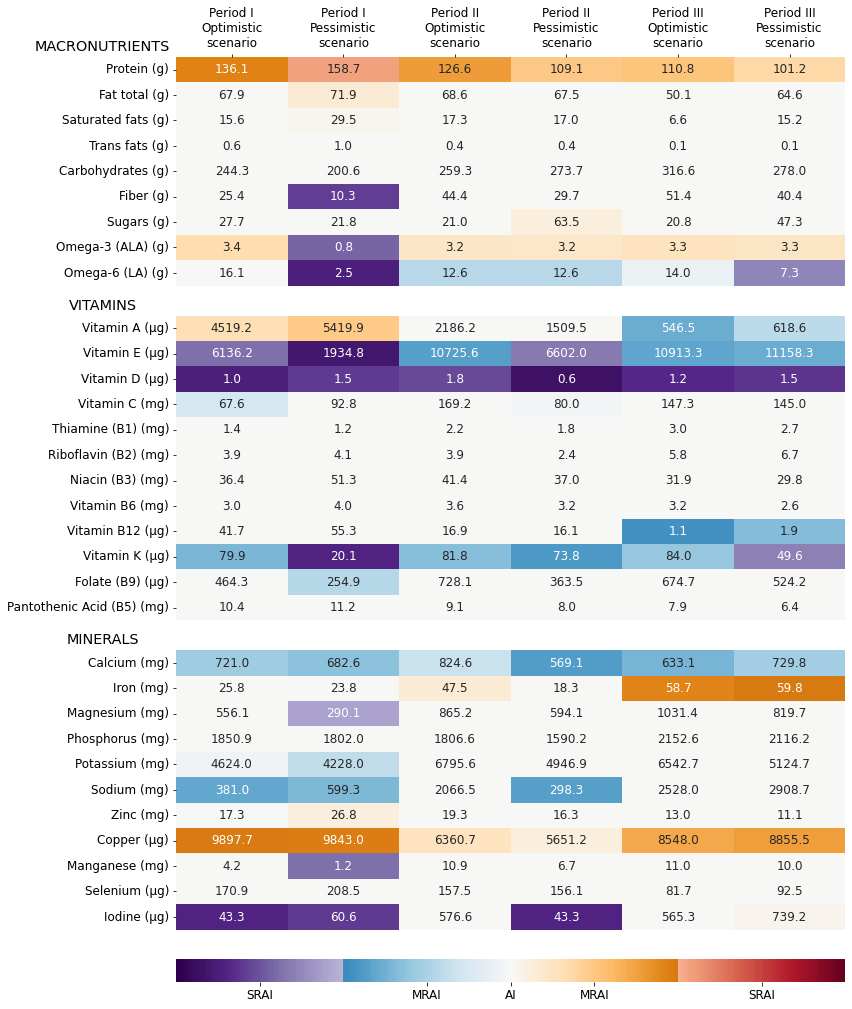

In [16]:
diets_heatmap = pd.DataFrame(columns= diets_final.columns, index=diets_final.index)
name_diets = ['Period I\nOptimistic\nscenario', 'Period I\nPessimistic\nscenario',
                       'Period II\nOptimistic\nscenario', 'Period II\nPessimistic\nscenario',
                       'Period III\nOptimistic\nscenario', 'Period III\nPessimistic\nscenario']

plt.rcParams.update({'font.size': 12})

max_factor = 2.0

cmap = 'PuOr'

def val_to_heatmap(x, ai_low, ai_high, mrai_low, mrai_high, srai_low, srai_high):
    if (x>=ai_low) and (x<=ai_high):
        v=1
    elif x<ai_low:
        if x>=mrai_low:
            v=(x-mrai_low)/(ai_low-mrai_low)
        elif x>=srai_low:
            v=(x-srai_low)/(mrai_low-srai_low)-1
        else:
            v=-1
    elif x>ai_high:
        if x<=mrai_high:
            v=(x-mrai_high)/(mrai_high-ai_high)+2
        elif x<=srai_high:
            v=(x-srai_high)/(srai_high-mrai_high)+3
        else:
            v=+2
    return v

for nutrient in diets_heatmap.index:
    ai_low = nut_needs.loc['Lower (moderate risk)', nutrient]
    ai_high = nut_needs.loc['Higher (safe)', nutrient]
    mrai_low = nut_needs.loc['Lower (severe risk)', nutrient]
    mrai_high = nut_needs.loc['Higher (moderate risk)', nutrient]
    srai_low = 0
    srai_high = nut_needs.loc['Higher (severe risk)', nutrient]
    for col in diets_heatmap.columns:
        diets_heatmap.loc[nutrient, col] = val_to_heatmap(diets_final.loc[nutrient, col],
                                                         ai_low, ai_high, mrai_low, mrai_high, srai_low, srai_high)

from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl

cmap1='PuOr'
cmap2='RdBu'

cmap1 = cm.get_cmap('PuOr', 256)
cmap1bis=cm.get_cmap('PiYG', 256)
cmap2 = cm.get_cmap('RdBu', 256)

Pu = list(reversed(cmap1(np.linspace(0,1,200))))[:64]
Or = list(reversed(cmap1(np.linspace(0,1,200))))[100:164]
Bu = list(reversed(cmap2(np.linspace(0,1,200))))[36:100]
Rd = list(reversed(cmap2(np.linspace(0,1,200))))[-64:]

RdOrBuPu = np.append(Pu, np.append(Bu, np.append(Or, Rd, axis=0), axis=0), axis=0)
cmap3 = ListedColormap(RdOrBuPu)

nutrients = [nutrient_names[:7]+nutrient_names[-2:],
#             nutrient_names[32:43],
             nutrient_names[7:19],
             nutrient_names[19:30]]

diets_heatmap = diets_heatmap.astype('float64')
diets_heatmap = diets_heatmap.rename(columns=dict(zip(diets_heatmap.columns, name_diets)))
#sns.heatmap(diets_heatmap, vmin=0, vmax=max_factor, cmap='PiYG', annot=diets_final)

#fig, axs = plt.subplots(2,2, figsize=(15,13), sharex=True)
#h_ratio = [len(nutrients[i]) for i in range(4)]+[4]
#fig, axs = plt.subplots(5, figsize=(12,15), sharex=True,
#                        gridspec_kw={'height_ratios': h_ratio})
h_ratio = [len(nutrients[i]) for i in range(3)]+[4]
fig, axs = plt.subplots(4, figsize=(12,15), sharex=True,
                        gridspec_kw={'height_ratios': h_ratio})

#title=['MACRONUTRIENTS', 'AMINO ACIDS', 'VITAMINS', 'MINERALS', '']
#ticks = [True, False, False, False]
title=['MACRONUTRIENTS', 'VITAMINS', 'MINERALS', '']
ticks = [True, False, False]
for i in range(3):
    sns.heatmap(diets_heatmap.loc[nutrients[i]], ax=axs[i], vmin=-1, vmax=3, cmap=cmap3,
                annot=diets_final.loc[nutrients[i]],
                fmt='.1f', cbar=False)
    axs[i].set_title(title[i], x=-0.11, y=1)
    axs[i].tick_params(labelbottom=False,labeltop=ticks[i], bottom=False, top=ticks[i])

fraction = 1

norm = mpl.colors.Normalize(vmin=-1, vmax=3)
cbar = axs[3].figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap3),
            ax=axs[3], pad=.05, fraction=fraction, orientation='horizontal',
            ticks=[-0.5, 0.5, 1, 1.5, 2.5], aspect=30)
cbar.set_ticklabels(['SRAI', 'MRAI', 'AI', 'MRAI', 'SRAI'])
cbar.outline.set_visible(False)
axs[3].axis('off')

fig.tight_layout()
plt.show()
fig.savefig('Heatmap_diets.pdf')
#fig.savefig('Heatmap_diets_commas.pdf')

In [10]:
diets_excel=pd.ExcelFile("Diets by period.xlsx")

sheets = diets_excel.sheet_names
diets = pd.DataFrame()

for sheet in sheets:
    diet_temp = pd.read_excel("Diets by period.xlsx", index_col=0, sheet_name=sheet)
    diet_temp = diet_temp.drop('Total:')
    food_subset = diet_temp.index
    nut_calc_subset=nut_calc.loc[list(food_subset)]
    nut_calc_subset_t=nut_calc_subset[nutrient_names[32:43]].T
    diet = nut_calc_subset_t @ (diet_temp['kcal']/100)
    diet_df = pd.DataFrame(diet, columns=[sheet])
    diets = diets.join(diet_df, how='outer')
diets_final = pd.DataFrame(diets, dtype=float)


AI_lower = pd.Series(nut_needs.T['Lower (moderate risk)'])
AI_upper = pd.Series(nut_needs.T['Higher (safe)'])
MRAI_lower = pd.Series(nut_needs.T['Lower (severe risk)'])
MRAI_upper = pd.Series(nut_needs.T['Higher (moderate risk)'])
SRAI_upper = pd.Series(nut_needs.T['Higher (severe risk)'])
df = diets_final.style.format(precision=2)

df.to_excel('Aminoacids per diet.xlsx')